# DVS Gesture Benchmark Tutorial

This tutorial aims to provide an insight on how the NeuroBench framework is organized and how you can use it to benchmark your own models!

## About DVS Gesture Benchmark Commands:
Mid-air gestures represent a natural modality of communication that holds benefits in a range of human-computer interaction applications owing to its touchless and efficient nature. Gesture recognition systems find utility in edge scenarios such as car infotainment systems, high-traffic public areas, or as alternative interaction modes for individuals with speech or hearing impairments.

### Dataset:
The IBM Dynamic Vision Sensor (DVS) Gesture dataset is composed of recordings of 29 distinct individuals executing 10 different types of gestures, including but not limited to clapping, waving, etc. Additionally, an 11th gesture class is
included that comprises gestures that cannot be categorized within the first 10 classes. The gestures are recorded under four distinct lighting conditions, and each gesture is associated with a label that indicates the corresponding lighting condition under which it was performed.

### Benchmark Task:
The task is a classification task. The benchmark task is to use samples from the 23 initial subjects as training and generalize to samples from the remaining 6 subjects.

First we will import the relevant libraries. These include the datasets, preprocessors and accumulators. To ensure your model to be compatible with the NeuroBench framework, we will import the wrapper for snnTorch models. This wrapper will not change your model. Finally, we import the Benchmark class, which will run the benchmark and calculate your metrics.

In [1]:
import torch
from torch.utils.data import DataLoader

import snntorch as snn

from torch import nn
from snntorch import surrogate

from neurobench.datasets import DVSGesture
from neurobench.models import SNNTorchModel
from neurobench.benchmarks import Benchmark
from neurobench.accumulators.accumulator import aggregate,choose_max_count

For this tutorial, we will make use of the example architecture that is included in the NeuroBench framework.

/home/korneel/.cache/pypoetry/virtualenvs/neurobench--0oLx93m-py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


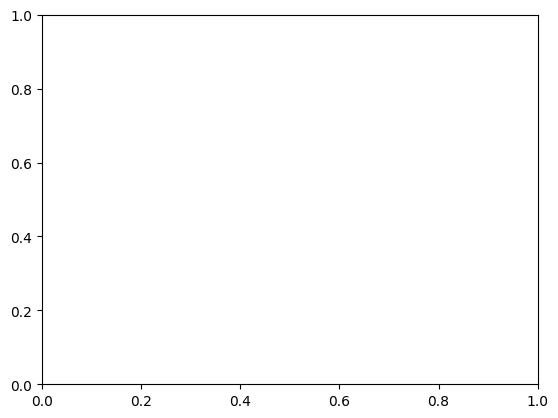

In [2]:
# this is the network we will be using in this tutorial
from neurobench.examples.dvs_gesture.CSNN import Conv_SNN

To get started, we will load our desired dataset in a dataloader. Note that upon initializing the dataset, the preprocessing can be applied to the dataset, avoiding the need for further preprocessing in the benchmark itself.

In [3]:

test_set = DVSGesture("data/dvs_gesture/", split="testing", preprocessing="stack")
test_set_loader = DataLoader(test_set, batch_size=16, shuffle=True,drop_last=True)

Next, load our model and wrap it in the corresponding NeuroBench wrapper. At the time of writing this tutorial, (V1.0) snnTorch is the only supported framework, therefore, we will wrap our snnTorch model in the SNNTorchModel() wrapper.

In [4]:
net = Conv_SNN()
net.load_state_dict(torch.load('neurobench/examples/dvs_gesture/model_data/DVS_SNN_untrained.pth'))

# wrap in SNNTorchModel wrapper
model = SNNTorchModel(net)

FileNotFoundError: [Errno 2] No such file or directory: 'neurobench/examples/dvs_gesture/model_data/DVS_SNN_untrained.pth'

Specify the preprocessor and postprocessor want to use. These will be applied to your data before feeding into the model, and to the output spikes respectively.
Available preprocessors and postprocessors can be found in neurobench/preprocessors and neurobench/accumulators respectively.

In [ ]:
# the dataset is already in the correct format, no preprocessing is needed
preprocessing = []

# postprocessors
postprocessors = [choose_max_count]


Next specify the metrics which you want to calculate. The available metrics (V1.0 release) are:

static_metrics:
*   model_size
*   connection_sparsity
*   frequency


data_metrics
*   activation_sparsity
*   multiply_accumulates
*   classification_accuracy

More explanation on the metrics can be found on https://neurobench.ai/.

In [ ]:
static_metrics = ["model_size"]
data_metrics = ["classification_accuracy"]

Next, we instanciate the benchmark. We have to specify the model, the dataloader, the preprocessors, the postprocessor and the list of the static and data metrics which we want to measure:

In [ ]:
benchmark = Benchmark(model, test_set_loader, preprocessors, postprocessors, [static_metrics, data_metrics])

Now, let's run the benchmark and print our results!

In [ ]:
results = benchmark.run()
print(results)